In [13]:
import os
from tqdm.notebook import tqdm
from deepmusic import MusicRepr, Constants
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import Audio
from joblib import Parallel, delayed
import pickle
import seaborn as sns

tqdm.pandas()

const = Constants(unit=4, num_tempo_bins=20, num_velocity_bins=20)

In [19]:
def process_file(file):
    seq = MusicRepr.from_file(path + file, const=const)
    tracks = seq.separate_tracks()
    ent = {'file' : file, 'n_bar': seq.get_bar_count()}
    for inst in const.instruments:
        if inst in tracks:
            ent[inst] = len(tracks[inst])
        else:
            ent[inst] = 0
    return ent

def make_df(path):
    files = list(filter(lambda x: x.endswith('.mid'), os.listdir(path)))
    print(len(files))
    res = Parallel(n_jobs=20)(delayed(process_file)(file) for file in tqdm(files))
    df = pd.DataFrame(res)
    df = df.sort_values('n_bar').reset_index(drop=True)
    df.to_csv(path + 'meta.csv')
    return df

def instrument_song_hist(df):
    plt.figure(figsize=(20,5))
    sns.barplot(x=const.instruments, y=[sum(df[inst] > 0) for inst in const.instruments])
    plt.show()
    
def instrument_event_hist(df):
    plt.figure(figsize=(20,5))
    sns.barplot(x=const.instruments, y=[sum(df[inst]) for inst in const.instruments])
    plt.show()

# LMD-matched dataset

In [6]:
path = '/home/soroosh/data/MIDI/LMD-Matched/lmd_processed/'

In [80]:
df = pd.read_csv('lmd_data.csv')
df.head()

,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,...,pipe,synth-lead,synth-pad,synth-effects,ethnic,percussive,sound-effects,drums,genre,style
0,9ceb6e6904becc8c2a75fe0c3a37657f.mid,453,0,0,0,1247,6407,1070,4331,2475,...,790,0,0,0,0,0,0,0,-,-
1,22a6ad62aebeb0612700f64d02dc18ec.mid,443,0,0,0,0,0,1178,11786,1540,...,1734,0,0,0,0,0,0,0,-,-
2,4fb43d0e8e8d263a5c97a797d8343a08.mid,405,7954,5133,0,4696,3553,0,0,0,...,0,0,4383,0,0,0,0,9507,-,-
3,a595d0ca98ca67de51306436cf23efae.mid,401,0,0,0,0,0,2648,10026,1090,...,1626,0,0,0,0,0,0,0,-,-
4,934b2b590e68fb5c6b7ea99b8292af51.mid,400,0,0,0,0,0,0,11299,1119,...,1610,0,0,0,0,0,0,0,-,-


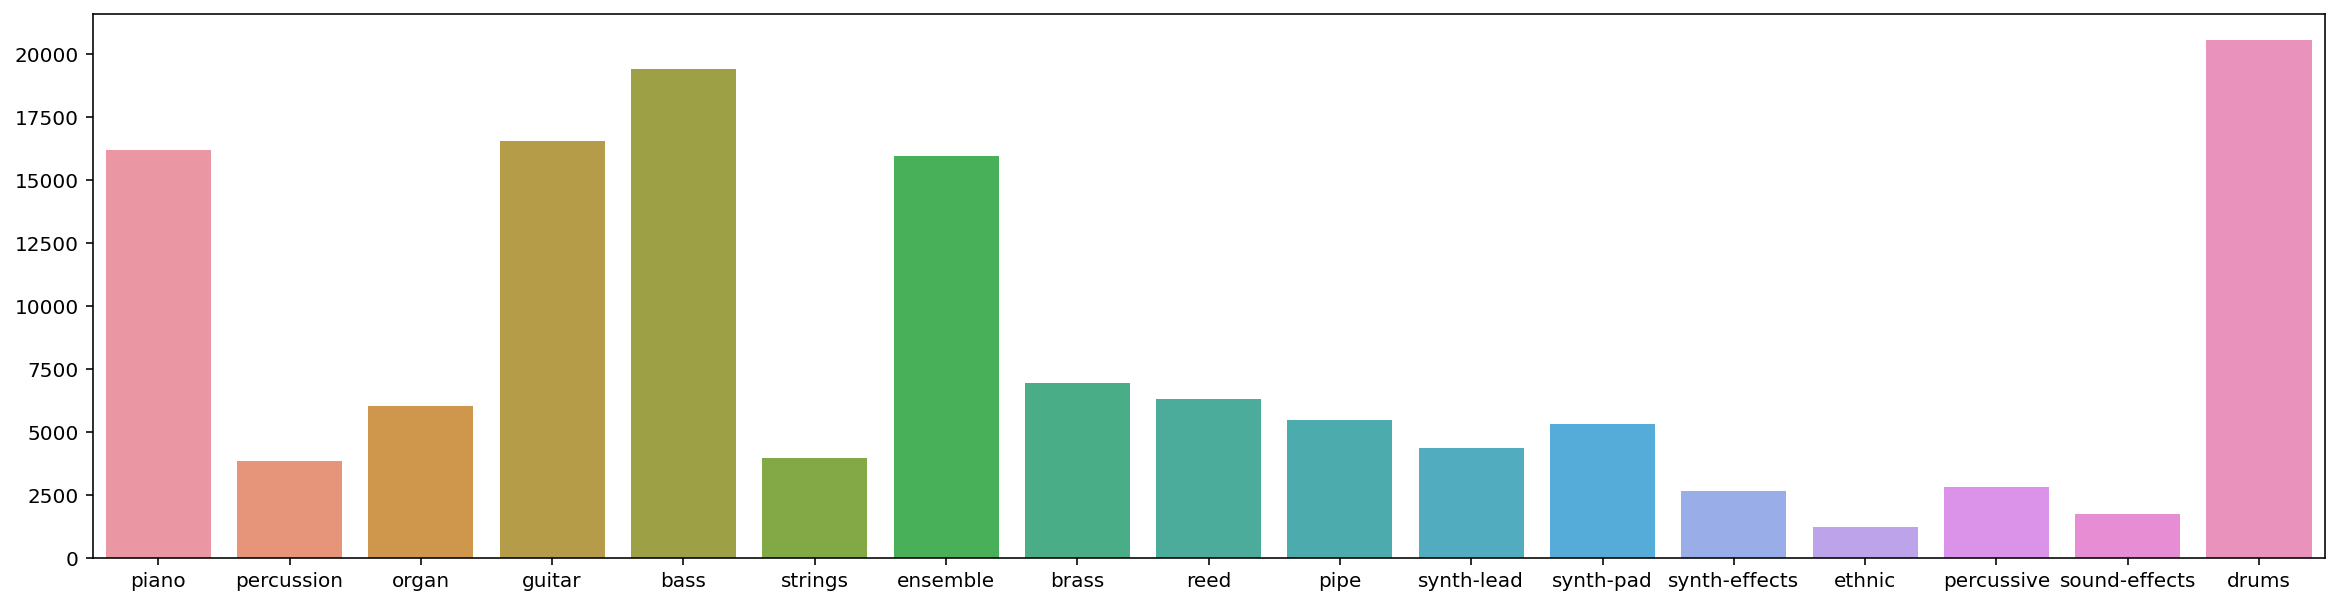

In [88]:
instrument_song_hist(df)

In [89]:
# df.to_csv('lmd_data.csv', index=False)

In [90]:
# f = open('/home/soroosh/data/MIDI/LMD-Matched/msd-MAGD-genreAssignment.cls')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# genre_map = {}
# for l in s:
#     a,b = l.split('\t')
#     genre_map[a] = b
    
# f = open('/home/soroosh/data/MIDI/LMD-Matched/msd-MASD-styleAssignment.cls')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# style_map = {}
# for l in s:
#     a,b = l.split('\t')
#     style_map[a] = b
    
# f = open('/home/soroosh/data/MIDI/LMD-Matched/file_paths.txt')
# s = f.read().strip().split('\n')
# f.close()
# print(len(s))

# hash_map = {}
# for l in s:
#     a,b = l.split('/')[-2:]
#     hash_map[b] = a
    
# print(len(set(style_map).intersection(set(genre_map))))

In [91]:
# df['genre'] = df['file'].apply(lambda x: genre_map[hash_map[x]] if hash_map[x] in genre_map else '')
# df['style'] = df['file'].apply(lambda x: style_map[hash_map[x]] if hash_map[x] in style_map else '')

In [92]:
# plt.figure(figsize=(28,10))
# plt.subplot(1,2,1)
# data = df[~df.genre.isin(['-', 'Pop_Rock'])].groupby('genre').count()
# sns.barplot(y=data.index, x=data.file)
# plt.subplot(1,2,2)
# data = df[df['style'] != '-'].groupby('style').count()
# sns.barplot(y=data.index, x=data.file)
# plt.show()

## customize for training

In [93]:
# plt.figure(figsize=(20,30))
# for i,inst in enumerate(const.instruments):
#     plt.subplot(len(const.instruments)//2 + 1, 2, i+1)
#     plt.title(inst)
#     plt.hist(df[inst], 50)

In [82]:
df2 = df[(df.piano > 0) & (df.guitar > 0) & (df.drums > 0) & (df.bass > 0) & (df.ensemble > 0)]
df2['sum_events'] = df2.progress_apply(lambda x: x['piano'] + x['guitar'] + x['drums'] + x['bass'] + x['ensemble'], axis=1)
df2['piano_frac'] = df2.progress_apply(lambda x: x['piano']/ x['sum_events'], axis=1)
df2['guitar_frac'] = df2.progress_apply(lambda x: x['guitar']/ x['sum_events'], axis=1)
df2['bass_frac'] = df2.progress_apply(lambda x: x['bass']/ x['sum_events'], axis=1)
df2['drums_frac'] = df2.progress_apply(lambda x: x['drums']/ x['sum_events'], axis=1)
df2['ensemble_frac'] = df2.progress_apply(lambda x: x['ensemble']/ x['sum_events'], axis=1)
df2['avg_event_per_bar'] = df2.progress_apply(lambda x: x['sum_events']/x['n_bar'], axis=1)
print(df2.shape)
df2.head()

  0%|          | 0/8566 [00:00<?, ?it/s]

  0%|          | 0/8566 [00:00<?, ?it/s]

  0%|          | 0/8566 [00:00<?, ?it/s]

  0%|          | 0/8566 [00:00<?, ?it/s]

  0%|          | 0/8566 [00:00<?, ?it/s]

  0%|          | 0/8566 [00:00<?, ?it/s]

  0%|          | 0/8566 [00:00<?, ?it/s]

(8566, 28)


,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,...,drums,genre,style,sum_events,piano_frac,guitar_frac,bass_frac,drums_frac,ensemble_frac,avg_event_per_bar
23,c301629e57f9a052b783601de8c43d45.mid,304,3077,1173,739,3176,2074,0,1017,604,...,8252,-,-,17596,0.174869,0.180496,0.117868,0.468970,0.057797,57.881579
29,9b00e3e07949ddb99638f4cf0c0a914c.mid,292,697,0,1696,3243,1788,0,695,0,...,4786,-,-,11209,0.062182,0.289321,0.159515,0.426978,0.062004,38.386986
33,1a2edb832812beeaab257acf69e2c7f1.mid,291,1830,0,0,11698,1779,0,292,0,...,4970,-,-,20569,0.088969,0.568720,0.086489,0.241626,0.014196,70.683849
44,233374fbff0c7397f8d8dfdbb3e31975.mid,280,3452,0,0,1543,1255,0,827,1329,...,9231,-,-,16308,0.211675,0.094616,0.076956,0.566041,0.050711,58.242857
46,dff023489ead8b9a5ede627bb23b39d8.mid,276,3235,0,789,1540,1243,0,978,1403,...,8947,-,-,15943,0.202910,0.096594,0.077965,0.561187,0.061344,57.764493


In [16]:
# df3 = df2[df2['genre'] != '-']
# print(df3.shape)

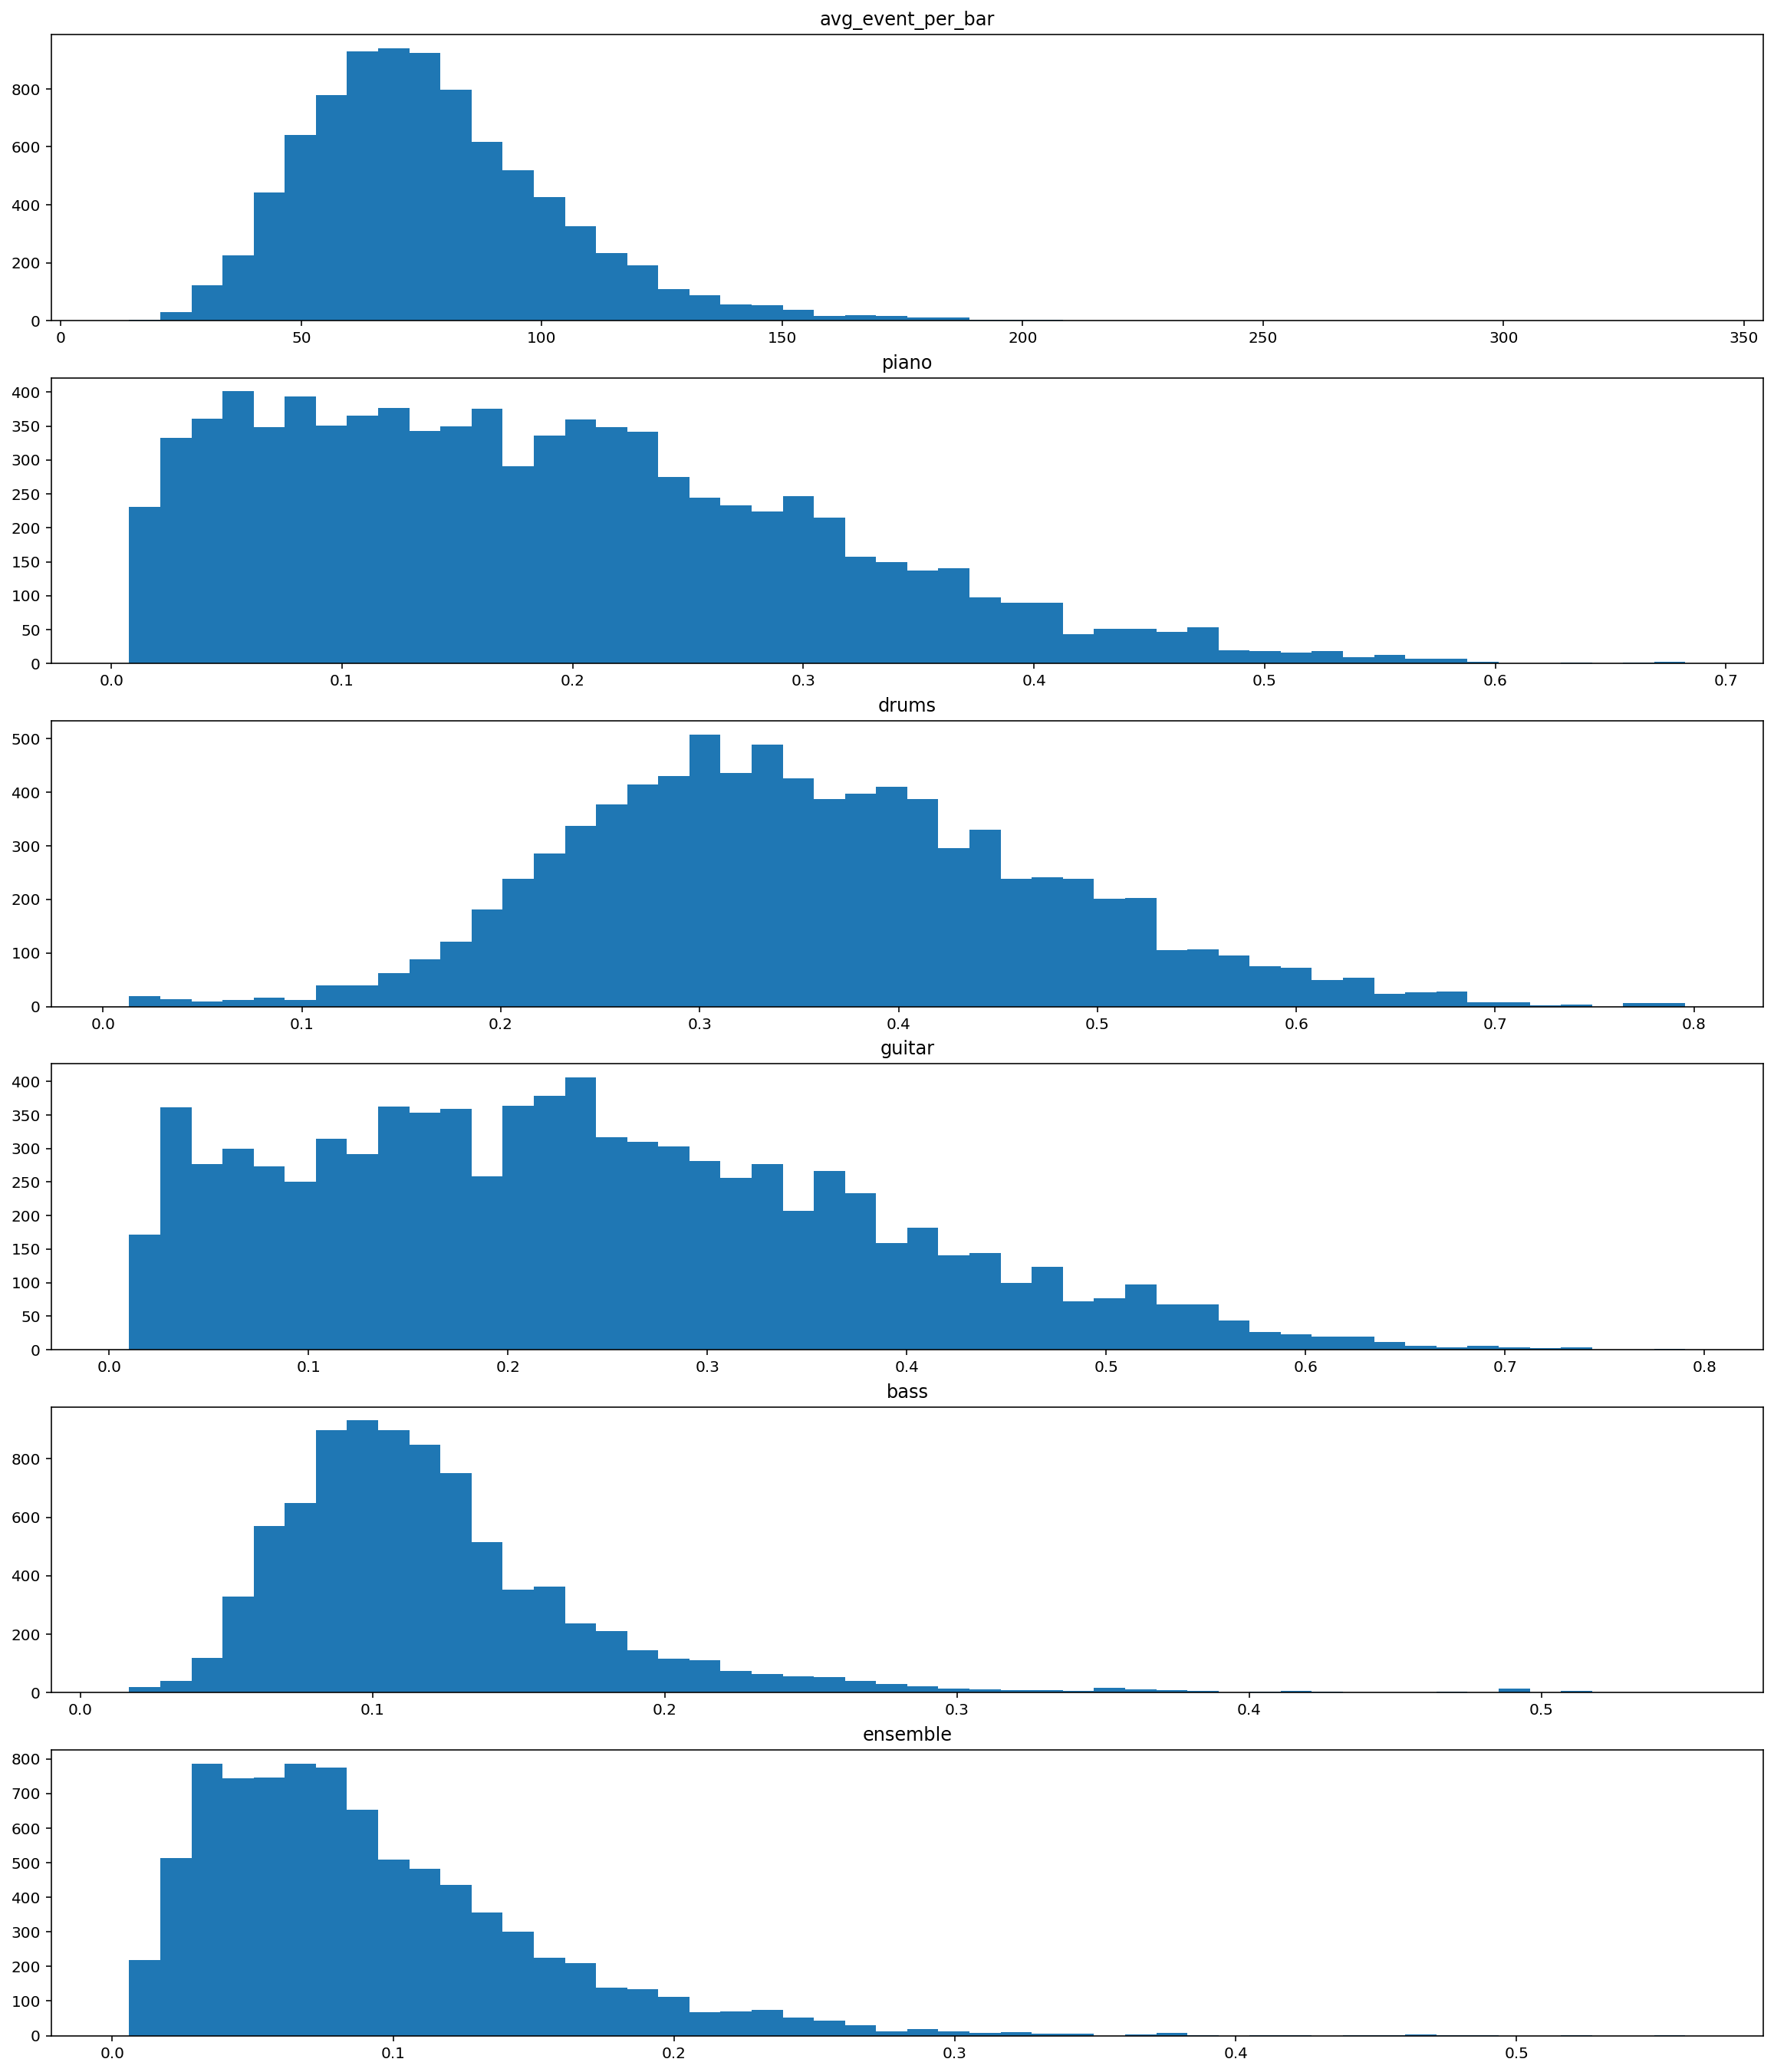

In [83]:
plt.figure(figsize=(20,24))
plt.subplot(6,1,1)
plt.title('avg_event_per_bar')
plt.hist(df2.avg_event_per_bar, 50)
plt.subplot(6,1,2)
plt.title('piano')
plt.hist(df2.piano_frac, 50)
plt.subplot(6,1,3)
plt.title('drums')
plt.hist(df2.drums_frac, 50)
plt.subplot(6,1,4)
plt.title('guitar')
plt.hist(df2.guitar_frac, 50)
plt.subplot(6,1,5)
plt.title('bass')
plt.hist(df2.bass_frac, 50)
plt.subplot(6,1,6)
plt.title('ensemble')
plt.hist(df2.ensemble_frac, 50)
plt.show()

In [87]:
df3 = df2[(df2.drums_frac > 0.1) & (df2.piano_frac > 0.1) & (df2.guitar_frac > 0.1) & (df2.bass_frac > 0.1) & (df2.ensemble_frac > 0.08)]
df3.shape

(1169, 28)

In [22]:
# df4 = df3[df3.drums_frac > 0.2]
# df4 = df4[~df4.genre.isin([
#     'Avant_Garde', 'Blues', 'Children', 'Classical', 'Stage ', 
#     'New Age', 'Reggae', 'Comedy_Spoken', 'Pop_Rock',
# ])]
# df3 = df3[['file', 'n_bar', 'piano', 'guitar', 'drums']]
# print(df4.shape)
# df4.head()

In [25]:
# plt.figure(figsize=(28,10))
# plt.subplot(1,2,1)
# data = df3.groupby('genre').count()
# sns.barplot(y=data.index, x=data.file)
# plt.subplot(1,2,2)
# data = df3.groupby('style').count()
# sns.barplot(y=data.index, x=data.file)
# plt.show()

In [24]:
files = df3.file.to_list()
pickle.dump(files, open('files.pkl', 'wb'))
len(files)

2283

## Jazz dataset

In [11]:
path = '/home/soroosh/data/MIDI/all_jazz/midis/'

In [25]:
# df = make_df(path)
print(df.shape)
df.head()

(851, 19)


,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,reed,pipe,synth-lead,synth-pad,synth-effects,ethnic,percussive,sound-effects,drums
0,CentralParkWest.mid,33,0,0,0,0,221,0,591,0,745,0,0,0,0,0,0,0,0
1,angeleye.mid,35,0,0,0,638,0,0,0,0,0,0,0,0,0,0,0,0,0
2,i_gotta_right_to_sing_the_blues_hh.mid,35,631,0,0,570,245,0,0,252,506,0,0,0,0,0,0,0,538
3,tempusfugit.mid,36,0,0,0,604,506,0,0,561,581,0,0,0,0,0,0,0,1169
4,inseparable_jlh.mid,40,1403,0,0,534,319,0,506,0,0,0,0,0,0,0,0,0,1579


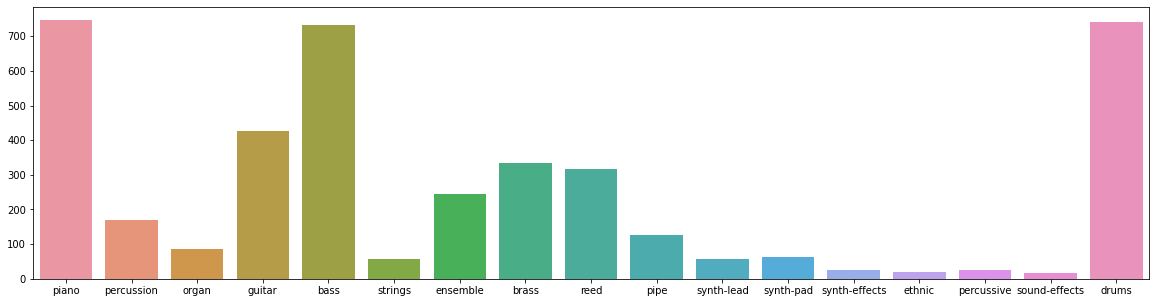

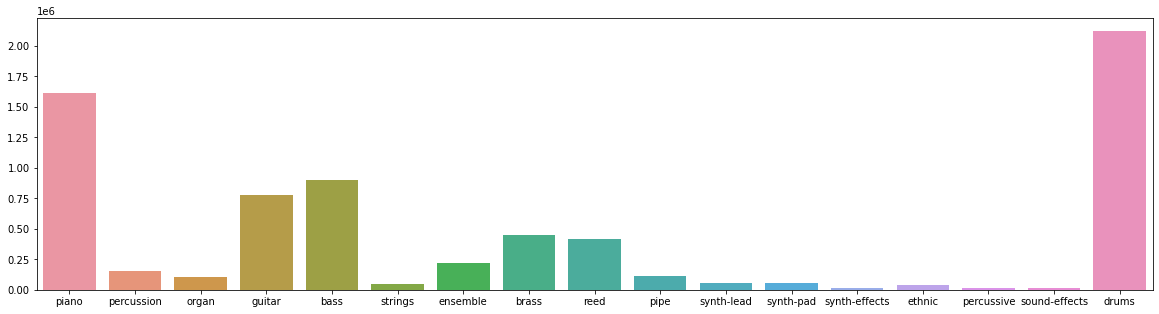

In [20]:
instrument_song_hist(df)
instrument_event_hist(df)

In [24]:
df[(df.piano > 0) | (df.drums > 0) | (df.guitar > 0) | (df.bass > 0)].shape

(850, 19)

In [26]:
df2 = df[(df.piano > 0) & (df.guitar > 0) & (df.drums > 0) & (df.bass > 0)]
df2['sum_events'] = df2.progress_apply(lambda x: x['piano'] + x['guitar'] + x['drums'] + x['bass'], axis=1)
df2['piano_frac'] = df2.progress_apply(lambda x: x['piano']/ x['sum_events'], axis=1)
df2['guitar_frac'] = df2.progress_apply(lambda x: x['guitar']/ x['sum_events'], axis=1)
df2['bass_frac'] = df2.progress_apply(lambda x: x['bass']/ x['sum_events'], axis=1)
df2['drums_frac'] = df2.progress_apply(lambda x: x['drums']/ x['sum_events'], axis=1)
df2['avg_event_per_bar'] = df2.progress_apply(lambda x: x['sum_events']/x['n_bar'], axis=1)
print(df2.shape)
df2.head()

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

  0%|          | 0/325 [00:00<?, ?it/s]

(325, 25)


,file,n_bar,piano,percussion,organ,guitar,bass,strings,ensemble,brass,...,ethnic,percussive,sound-effects,drums,sum_events,piano_frac,guitar_frac,bass_frac,drums_frac,avg_event_per_bar
2,i_gotta_right_to_sing_the_blues_hh.mid,35,631,0,0,570,245,0,0,252,...,0,0,0,538,1984,0.318044,0.287298,0.123488,0.271169,56.685714
4,inseparable_jlh.mid,40,1403,0,0,534,319,0,506,0,...,0,0,0,1579,3835,0.365841,0.139244,0.083181,0.411734,95.875000
11,xtracrispy.mid,44,643,366,0,264,598,0,246,798,...,0,0,0,1725,3230,0.199071,0.081734,0.185139,0.534056,73.409091
14,you_belong_to_me_rs.mid,45,2354,0,0,331,488,0,765,0,...,0,0,0,1234,4407,0.534150,0.075108,0.110733,0.280009,97.933333
17,she-ECostello_mkc.mid,48,908,0,383,1005,424,0,717,0,...,0,0,0,1015,3352,0.270883,0.299821,0.126492,0.302804,69.833333


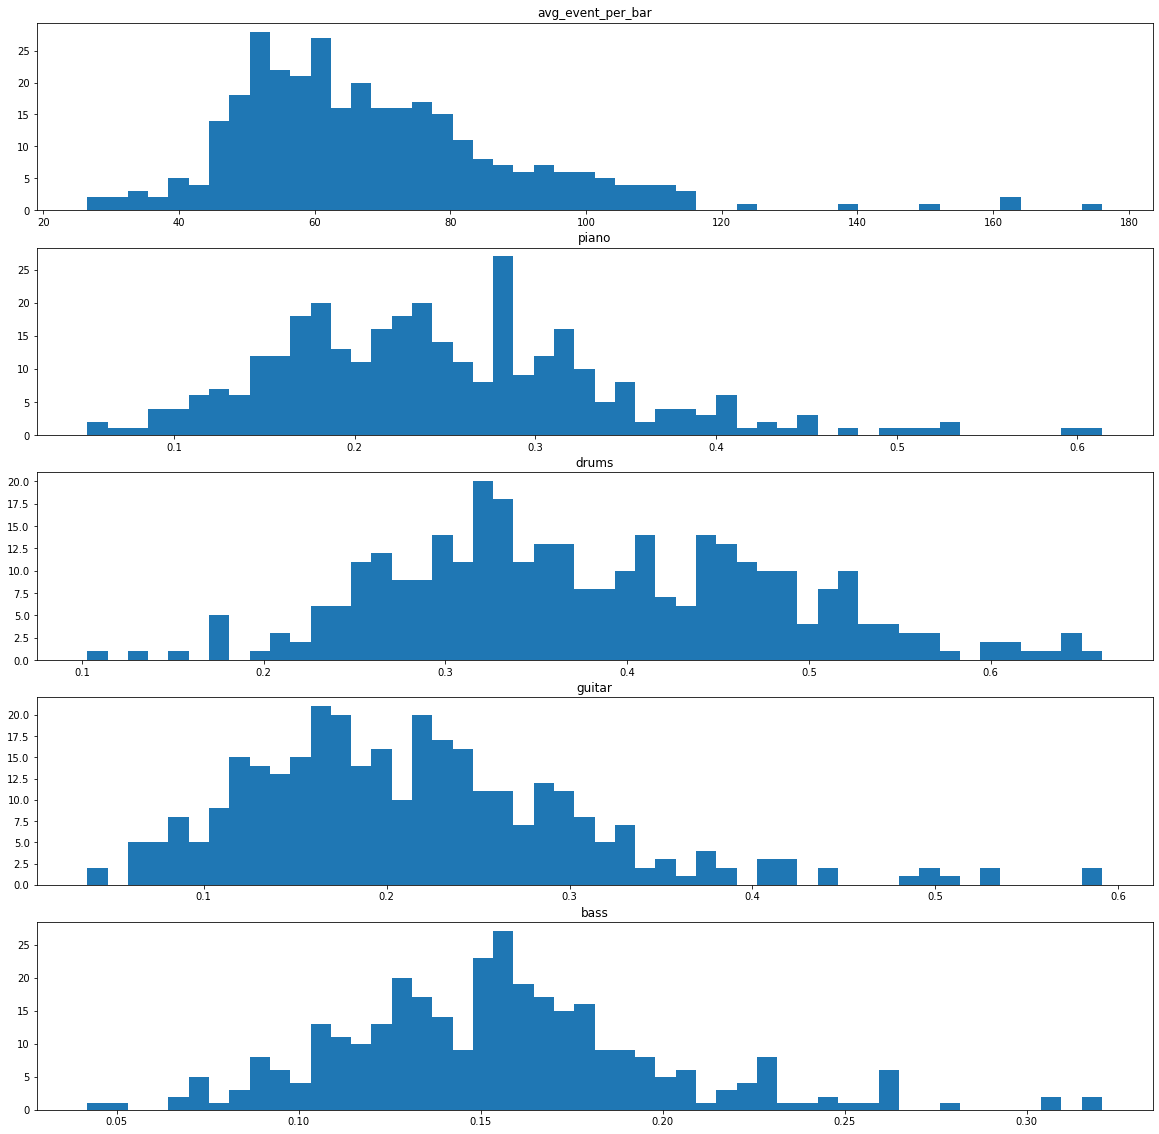

In [27]:
plt.figure(figsize=(20,20))
plt.subplot(5,1,1)
plt.title('avg_event_per_bar')
plt.hist(df2.avg_event_per_bar, 50)
plt.subplot(5,1,2)
plt.title('piano')
plt.hist(df2.piano_frac, 50)
plt.subplot(5,1,3)
plt.title('drums')
plt.hist(df2.drums_frac, 50)
plt.subplot(5,1,4)
plt.title('guitar')
plt.hist(df2.guitar_frac, 50)
plt.subplot(5,1,5)
plt.title('bass')
plt.hist(df2.bass_frac, 50)
plt.show()

# G2G dataset

In [23]:
path = '/home/soroosh/data/MIDI/groove2groove-data-v1.0.0/'
styles = pd.read_table(path + 'styles.tsv')
print(styles.shape)
styles.head()

(1476, 9)


,Name,TSig,EvSw,Tempo,Long Name,Genre,Group,#Instr,Other Genres
0,128_45,12/8,sw8,45,12/8 at T=45 - Slow 12/8 Jazz,Jazz,Jazz,5,"Jazz Ballad,Jazz Swing"
1,128ORK,12/8,sw8,70,Orchestral 12/8,Classical,Country,4,Orchestral
2,128Rok1,12/8,sw8,70,12/8 Power Rock Ballad,Medium Rock,Pop,5,"Power Ballad,Ballad,Lite Pop"
3,128Rok2,12/8,sw8,65,12/8 Loud Rock Feel,Medium Rock,Pop,5,"Lite Pop,Doo Wop"
4,12_8Surf,12/8,sw8,70,12/8 Surf - Slow 12/8 - 60s Pop,Lite Pop,Pop,5,"Surf,Doo Wop"


In [30]:
df = pd.DataFrame(columns=['file', 'split', 'chart', 'style', 'substyle'])
for split in ['train', 'test', 'val', 'itest']:
    for file in tqdm(os.listdir(path + f'midi/{split}/fixed/')):
        df = df.append({
                'file': file, 
                'split' : split, 
                'chart': file.split('.')[0], 
                'style': '_'.join(file.split('.')[1].split('_')[:-1]), 
                'substyle': file.split('.')[1].split('_')[-1]
            }, ignore_index=True)

df.to_csv(path + 'meta.csv', index=False)
print(df.shape)
df.head()

(9333, 5)


,file,split,chart,style,substyle
0,maj469.R_RAP1_b.mid,train,maj469,R_RAP1,b
1,maj800.CC_SHAWN_a.mid,train,maj800,CC_SHAWN,a
2,maj777.J!~HONEY_a.mid,train,maj777,J!~HONEY,a
3,maj614.YEARN_a.mid,train,maj614,YEARN,a
4,maj722.Z3BLUSHF_a.mid,train,maj722,Z3BLUSHF,a
